In [29]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [30]:
### Note that different pairs of spins should have different bonds
### Hence we use dictionary as the implementation for the bonds
### However the order in the pair doesn't matter, hence we use frozenset as the keys for dictionary
def get_bound_EA(index1, index2, bonds):
    bond = frozenset({tuple(index1),tuple(index2)})
    if bond in bonds:
        return bonds[bond]
    else:
        bonds[bond] = np.random.standard_normal()
        return bonds[bond]

In [155]:
bonds = dict()

In [6]:
def increase_entry_by_one(A, j):
    A_modified = A.copy()
    A_modified[j] += 1
    return A_modified

In [7]:
def decrease_entry_by_one(A, j):
    A_modified = A.copy()
    A_modified[j] -= 1
    return A_modified

In [8]:
def get_neighbor(indices,L):
    neighbor_index = []
    for j in range(len(indices)):
        if (indices[j] == 0):
            neighbor_index.append(increase_entry_by_one(indices, j))
            indice_copy = indices.copy()
            indice_copy[j] = L-1
            neighbor_index.append(indice_copy)
        elif (indices[j] == L-1):
            neighbor_index.append(decrease_entry_by_one(indices, j))
            indice_copy = indices.copy()
            indice_copy[j] = 0
            neighbor_index.append(indice_copy)
        else:
            neighbor_index.append(increase_entry_by_one(indices, j))
            neighbor_index.append(decrease_entry_by_one(indices, j))
    return neighbor_index

In [9]:
def get_energy(spin, spin_index, neighbor_index, S):
    energy = 0
    for neighbor in neighbor_index:
        bond = get_bound_EA(spin_index, neighbor, bonds)
        energy = energy + bond*spin*S[tuple(neighbor)]
    return energy

In [156]:
def overlap(S1,S2,N):
    return np.sum(S1*S2)/N

def sweep(S,L,N):
    sweep = 0
    while sweep < N:
        indices = [np.random.choice(dim) for dim in S.shape]
        spin = S[tuple(indices)]
        neighbor_index = get_neighbor(indices,L)
        beforeE = get_energy(spin, indices, neighbor_index, S)
        afterE = get_energy(-spin, indices, neighbor_index, S)
        deltaE = afterE - beforeE
        if deltaE > 0:
            S[tuple(indices)] = -spin
        sweep = sweep+1

In [50]:
def is_active(index, S, L):
    spin = S[tuple(index)]
    neighbor_index = get_neighbor(np.asarray(index),L)
    neighbor = np.array([S[tuple(index)] for index in neighbor_index])
    beforeE = get_energy(spin, index, neighbor_index, S)
    afterE = get_energy(-spin, index, neighbor_index, S)
    deltaE = afterE - beforeE
    return deltaE > 0

In [51]:
def get_active(S,L):
    it = np.nditer(S,flags = ['multi_index'])
    active_indices = []
    while not it.finished:
        index = it.multi_index
        if is_active(index, S, L):
            active_indices.append(index)
        it.iternext()
    return active_indices

In [157]:
length = 100
dimension = 2
N = length ** dimension
model = 'EA'
config = np.random.choice([-1, 1], size=tuple([length] * dimension))
S2 = config.copy()
S1 = config.copy()

1.0


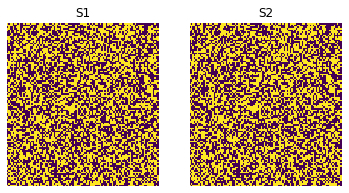

In [158]:
figure = plt.figure(figsize=(6, 3))
figure.add_subplot(1, 2, 1)
plt.title('S1')
plt.axis("off")
plt.pcolor(S1)
figure.add_subplot(1, 2, 2)
plt.title('S2')
plt.axis("off")
plt.pcolor(S2)
print(overlap(S1,S2,N))

In [152]:
'''survival1 = 0
survival2 = 0
while True:
    if sweep(S1,length,N) == False:
        break
    survival1 = survival1 + 1
while True:
    if sweep(S2,length,N) == False:
        break
    survival2 = survival2 + 1'''

In [159]:
overlap(S1,S2,N)

1.0

In [160]:
sweep(S1,length,N)

In [161]:
sweep(S1,length,N)
len(get_active(S1,length))

561

In [162]:
sweep(S1,length,N)
len(get_active(S1,length))

268

In [163]:
sweep(S1,length,N)
len(get_active(S1,length))

127

In [164]:
sweep(S1,length,N)
len(get_active(S1,length))

60

In [165]:
sweep(S1,length,N)
len(get_active(S1,length))

35

In [166]:
sweep(S1,length,N)
len(get_active(S1,length))

21

In [167]:
sweep(S1,length,N)
len(get_active(S1,length))

10

In [168]:
sweep(S1,length,N)
len(get_active(S1,length))

5

In [169]:
sweep(S1,length,N)
len(get_active(S1,length))

5

In [170]:
sweep(S1,length,N)
len(get_active(S1,length))

2

In [171]:
sweep(S1,length,N)
len(get_active(S1,length))

1

In [172]:
sweep(S1,length,N)
len(get_active(S1,length))

0

In [173]:
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
sweep(S2,length,N)
len(get_active(S2,length))

0

In [174]:
overlap(S1,S2,N)

0.4172